In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
#Yearly interest
r = 0.01
R0 = np.exp(r)

# Functions

In [3]:
def sample_V(R1, years, sample_size, p, c, yearly_investment=1000):
    frac = lambda k: p*(1-c*(k-1)/30)
    q = np.array([frac(i+1) for i in range(30)])
    phi = q*(R1 - R0) + R0
    return pd.DataFrame(yearly_investment*phi.sort_index(axis=1,ascending=False).cumprod(axis=1).sum(axis=1))

def sample_V_rec(R1, years, sample_size, p, c, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            frac = p*(1-c*(k)/30)
            V = (yearly_investment + V)*frac*R1.iloc[i,k] + (1-frac)*(yearly_investment + V)*R0
        temp.append(V)
    return pd.DataFrame(temp)

def sample_V_TI(R1, years, sample_size, r_bar, yearly_investment=1000):
    G = np.array([yearly_investment*np.exp(r_bar*(j+1)) for j in range(years)]).cumsum()
    phi = G + (yearly_investment - G*np.exp(-r))*R1#(R0-R1)*G*np.exp(-r) + yearly_investment*np.exp(-r)*R1
    
    R1_aug = R1.shift(-1, axis=1)
    R1_aug[years-1] = 1

    return pd.DataFrame((phi * R1_aug.sort_index(axis=1, ascending=False).cumprod(axis=1).sort_index(axis=1)).sum(axis=1))

def sample_V_TI_rec(R1, years, sample_size, r_bar, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            V = (V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k] + G*np.exp(-r)*R0
        temp.append(V)

    return pd.DataFrame(temp)

def sample_V_lev(R1, years, sample_size, r_bar, leverage=1, yearly_investment=1000):
    V_list = []
    for i in range(sample_size):
        V = 0
        strat = True
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            
            if strat:
                V = (V + yearly_investment - leverage*(V + yearly_investment - G*np.exp(-r)))*R0 + leverage*(V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k]
            else:
                V = (V + 1000)*R0
            if G>V:
                strat = False
            else:
                strat = True
                
        V_list.append(V)
        
    return pd.DataFrame(V_list)

def emp_dist(x, samples):
    ind = samples < x
    return (ind.sum()/samples.shape[0])[0]

def emp_quantile(p, samples):
    samples = samples.sort_values(by=0)
    ind = int(samples.shape[0]*(1-p))
    return samples.loc[ind][0]

def plot_emp_dist(samples, sample_lenght=10):
    samples = samples.sort_values(by=0)
    h = sample_lenght*samples.shape[0]
    interval = samples.iloc[-1][0] - samples.iloc[0][0]
    delta = interval/h
    
    x = [samples.iloc[0][0] + i*delta for i in range(h)]
    y = [emp_dist(i, samples) for i in x]

    return x,y

# Synthetic Data

In [4]:
sample_size = int(1e4)
years = 30
my, sigma = 0.03, 0.2

Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
R1 = np.exp(my + sigma*Z)

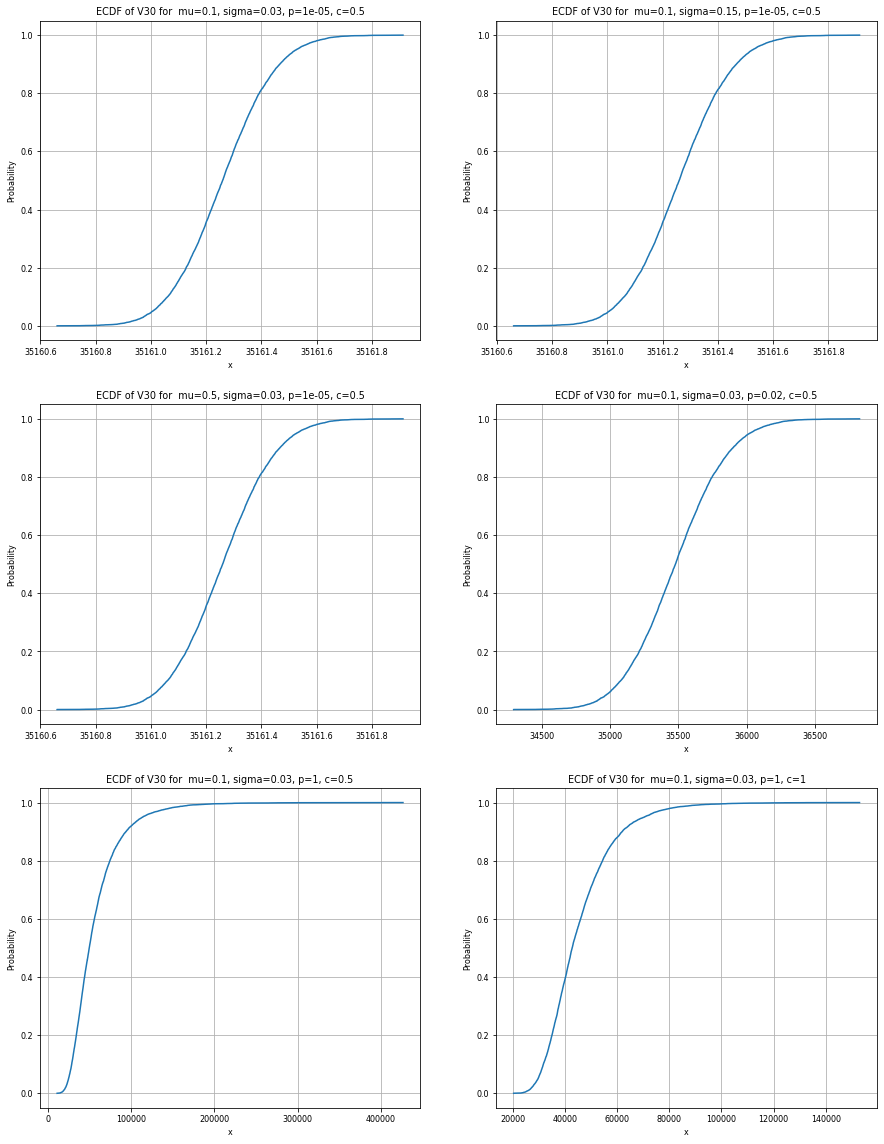

In [5]:
plt.rcParams['axes.formatter.useoffset'] = False

my = [0.1, 0.1, 0.5, 0.1, 0.1, 0.1] 
sigma = [0.03, 0.15, 0.03, 0.03, 0.03, 0.03]
p = [1e-5, 1e-5, 1e-5, 0.02, 1, 1]
c = [5e-1, 5e-1, 5e-1, 5e-1, 5e-1, 1]
ax = {}
plt.rcParams.update({'font.size': 8})
fig=plt.figure(figsize=(15,20))
for i in range(6): # i = 0 & 1
    V30 = sample_V(R1, years, sample_size, p[i], c[i], yearly_investment=1000)
    x,y = plot_emp_dist(V30)
    ax[i] = fig.add_subplot(int('32' + str(i+1)))
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('Probability')

    ax[i].set_title(f'ECDF of V30 for  mu={my[i]}, sigma={sigma[i]}, p={p[i]}, c={c[i]}') 
    ax[i].grid()
    plt.plot(x, y)

plt.savefig('ecdf.jpg')
plt.show()

In [6]:
#p, c = 1e-5, 5e-1
C_ = 10
V0 = 35161.10170990864
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - (C_/(2*V0))*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

In [ ]:
#Clearly small p of order 1e-5 and c of order 1e-1 gives good mean variance max.
params[V_30s.sort_values(by=0).index[-10:]]

array([[0.24416587, 0.77930039],
       [0.24417709, 0.77932041],
       [0.24416528, 0.77934377],
       [0.24419509, 0.77937755],
       [0.2441949 , 0.77938038],
       [0.24416608, 0.77930844],
       [0.24419546, 0.77939896],
       [0.24418977, 0.7793776 ],
       [0.24418668, 0.77936276],
       [0.24418428, 0.77936986]])

In [6]:
p, c = [0.24418428, 0.77936986]#params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)

print(f'{np.round(emp_quantile(0.01, V_30),2)} & {np.round(V_30.mean()[0],2)} & {np.round(V_30.median()[0],2)} & {np.round(V_30.max()[0],2)}')
print(f'Mean: {V_30.mean()[0]}, Median: {V_30.median()[0]}, 1% Quantile: {emp_quantile(0.01, V_30)}, Max: {V_30.max()[0]}')

40200.08 & 38219.53 & 37975.51 & 54615.59
Mean: 38219.5260751966, Median: 37975.5107822601, 1% Quantile: 40200.07668721946, Max: 54615.593532380626


In [7]:
r_bar = 0.005

V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
print(f'{np.round(emp_quantile(0.01, V_30_TI),2)} & {np.round(V_30_TI.mean()[0],2)} & {np.round(V_30_TI.median()[0],2)} & {np.round(V_30_TI.max()[0],2)}')
print(f'Mean: {V_30_TI.mean()[0]}, Median: {V_30_TI.median()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}, Max: {V_30_TI.max()[0]}')

36499.35 & 36850.66 & 36076.9 & 80367.7
Mean: 36850.658076580024, Median: 36076.902012595645, 1% Quantile: 36499.34584520101, Max: 80367.69559627972


In [8]:
r_bar = 0.005
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=2)
print(f'{np.round(emp_quantile(0.01, sample_lev),2)} & {np.round(sample_lev.mean()[0],2)} & {np.round(sample_lev.median()[0],2)} & {np.round(sample_lev.max()[0],2)}')
print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}, Max: {sample_lev.max()[0]}')

36297.53 & 40003.17 & 35894.79 & 718122.2
Mean: 40003.17353702549, Median: 35894.785013073444, 1% Quantile: 36297.53431276962, Max: 718122.1977973293


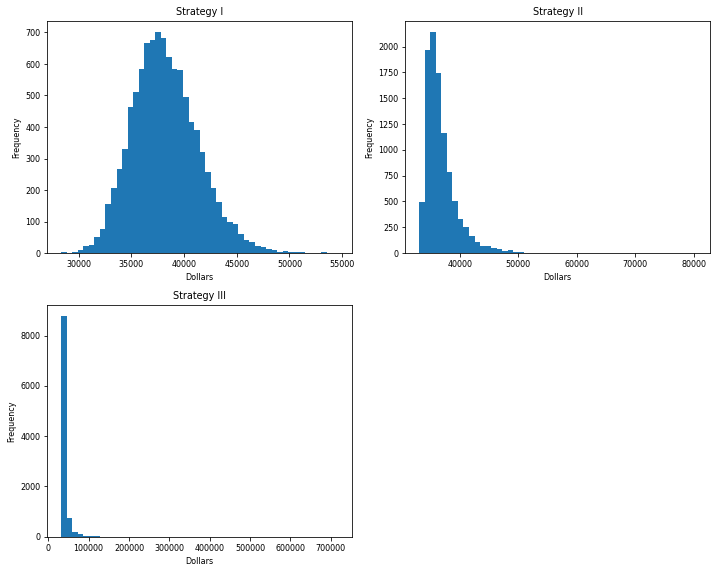

In [9]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221)
ax1.set_xlabel('Dollars')
ax1.set_ylabel('Frequency')
ax1.set_title("Strategy I")
plt.hist(V_30.values, bins=50)
ax2 = fig.add_subplot(222)
plt.hist(V_30_TI.values, bins=50)
ax2.set_xlabel('Dollars')
ax2.set_ylabel('Frequency')
ax2.set_title("Strategy II")
ax3 = fig.add_subplot(223)
plt.hist(sample_lev.values, bins=50)
ax3.set_xlabel('Dollars')
ax3.set_ylabel('Frequency')
ax3.set_title("Strategy III")
plt.tight_layout()
plt.savefig('histograms_synthetic.png')

# Real World Data

In [ ]:
data = yf.Ticker("SPY").history(period='MAX')
close = data['Close']
dim = 25
rets = close.pct_change(dim) + 1 # montly return
#rets = rets[dim:]
monthly_rets = rets[[dim*(i+1) for i in range(int(rets.shape[0]/dim))]]

In [ ]:
months = 12 #Month in 30 years
yearly_historical = pd.DataFrame(np.random.choice(monthly_rets.values, size=(100*sample_size, months), replace=True)).prod(axis=1)

In [ ]:
sample_size = int(1e4)
years = 30
R1 = pd.DataFrame(np.random.choice(yearly_historical.values, size=(sample_size, years), replace=True))

In [ ]:
dives = 3
high = 1
low = 0
for d in range(dives):
    V_30s = []
    params = np.random.uniform(high = high, low = low, size=(10000,2))
    for p,c in params:    
        V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
        mean = V_30.mean()
        var = V_30.var()
        V_30s.append((mean - (C_/(2*V0))*var)[0])
        #V_30.plot.hist(bins=50)
    V_30s = pd.DataFrame(V_30s)
    high = params[V_30s.sort_values(by=0).index[-10:]].max(axis=0)
    low = params[V_30s.sort_values(by=0).index[-10:]].min(axis=0)

In [ ]:
params[V_30s.sort_values(by=0).index[-1:]]

In [ ]:
p, c = params[V_30s.sort_values(by=0).index[-1:]][0]
V_30 = sample_V(R1, years, sample_size, p, c, yearly_investment=1000)
print(f'{np.round(emp_quantile(0.01, V_30),2)} & {np.round(V_30.mean()[0],2)} & {np.round(V_30.median()[0],2)} & {np.round(V_30.max()[0],2)}')
print(f'Mean: {V_30.mean()[0]}, Median: {V_30.median()[0]}, 1% Quantile: {emp_quantile(0.01, V_30)}, Max: {V_30.max()[0]}')

In [ ]:
V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
print(f'{np.round(emp_quantile(0.01, V_30_TI),2)} & {np.round(V_30_TI.mean()[0],2)} & {np.round(V_30_TI.median()[0],2)} & {np.round(V_30_TI.max()[0],2)}')
print(f'Mean: {V_30_TI.mean()[0]}, Median: {V_30_TI.median()[0]}, 1% Quantile: {emp_quantile(0.01, V_30_TI)}, Max: {V_30_TI.max()[0]}')

In [ ]:
sample_lev = sample_V_lev(R1, years, sample_size, r_bar, leverage=2)
print(f'{np.round(emp_quantile(0.01, sample_lev),2)} & {np.round(sample_lev.mean()[0],2)} & {np.round(sample_lev.median()[0],2)} & {np.round(sample_lev.max()[0],2)}')
print(f'Mean: {sample_lev.mean()[0]}, Median: {sample_lev.median()[0]}, 1% Quantile: {emp_quantile(0.01, sample_lev)}, Max: {sample_lev.max()[0]}')

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221)
ax1.set_xlabel('Dollars')
ax1.set_ylabel('Frequency')
ax1.set_title("Strategy I")
plt.hist(V_30.values, bins=50)
ax2 = fig.add_subplot(222)
plt.hist(V_30_TI.values, bins=50)
ax2.set_xlabel('Dollars')
ax2.set_ylabel('Frequency')
ax2.set_title("Strategy II")
ax3 = fig.add_subplot(223)
plt.hist(sample_lev.values, bins=50)
ax3.set_xlabel('Dollars')
ax3.set_ylabel('Frequency')
ax3.set_title("Strategy III")
plt.tight_layout()
#plt.savefig("normalvars.png", dpi=150)
plt.savefig('histograms_real.png')

In [ ]:
my = np.log(yearly_historical).mean()
std = np.log(yearly_historical).std()